In [2]:
import pandas as pd
import scanpy as sc
import decoupler as dc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({'axes.grid' : False})
import gseapy as gp
from matplotlib_venn import venn3
plt.rcParams['pdf.fonttype'] = 42


import sys
scr_path = '/nfs/team292/hm11/endo_GLND/starsolo/GLND/Thyroid/snippets'
sys.path.append(scr_path)
import singleCellFun as sf

import warnings
warnings.filterwarnings('ignore')

# prep single cell data

In [3]:
# get single cell data
fname = '../../Thyrocytes/workingObj/adata_thy_ALL_harm_noStressEmb.h5ad'
adata = sc.read(fname)
sf.summaryTable(adata,['sample','karyotype','gender','donor','pcw'])

# add age groups
labels = ['9-10','11-13','14-20']
adata.obs['age_group'] = pd.cut(adata.obs['pcw'].astype(int), bins=[0, 10, 13, 20], include_lowest=True, labels=labels).rename('age_group')

[INFO] - total cells: 49853


In [4]:
# add celltype annotations
annot = pd.read_csv('../../Thyrocytes/workingObj/adata_thy_ALL_harm_annotations.csv', index_col=0)
adata.obs = pd.concat([adata.obs.loc[:,~adata.obs.columns.isin(annot.columns)], annot], axis=1)

In [5]:
def pp_norm(adata, celltype):
    subdata = adata[adata.obs['celltype'].isin(celltype)]
    sc.pp.filter_cells(subdata, min_genes=1000)
    sc.pp.filter_genes(subdata, min_cells=3)
    subdata.X = subdata.layers['counts'].copy()
    df = subdata.to_df()
    mat_norm = df.div(df.sum(axis=1), axis='index')
    print(f'df shape: {mat_norm.shape}')
    return mat_norm 

In [6]:
# norm counts by cells
# The legacy name 'thy_TH_processing’ was previously used for ‘fTFC1’.
# The legacy name ‘thy_Lumen-forming’ was previously used for ‘fTFC2’.

pro_norm = pp_norm(adata, ['thy_TH_processing'])
lum_norm = pp_norm(adata, ['thy_Lumen-forming'])

df shape: (29434, 27588)
df shape: (13325, 26005)


In [7]:
# make mean per group
adata.obs['KA'] = adata.obs['karyotype'].astype(str)+'_'+adata.obs['age_group'].astype(str)

In [8]:
lum_norm_KA = pd.concat([lum_norm,adata.obs['KA']], axis=1)
pro_norm_KA = pd.concat([pro_norm,adata.obs['KA']], axis=1)

In [9]:
lum_mean = lum_norm_KA.groupby('KA').mean()
pro_mean = pro_norm_KA.groupby('KA').mean()

In [10]:
EXP_THRISH = 5E-6
lum_higenes = lum_mean.loc[:,lum_mean.max(axis=0) > EXP_THRISH].columns.tolist()
pro_higenes = pro_mean.loc[:,pro_mean.max(axis=0) > EXP_THRISH].columns.tolist()

hiexpgenes = list(set(lum_higenes) | set(pro_higenes))
len(hiexpgenes)

13822

In [11]:
# filter genes by min cells and %cells
higenes, groups = sf.getExpPercGroup(adata, ['karyotype','age_group','celltype'], min_cells = 20,  min_pct = 0.1)

HIgnees = list(set(hiexpgenes) & set(higenes))
len(HIgnees)

[INFO] 12 aggs using ['karyotype', 'age_group', 'celltype'] at min_cells=20,  min_pct=0.1. 12270 genes


['2n_11-13_thy_Cycling',
 '2n_11-13_thy_Lumen-forming',
 '2n_11-13_thy_TH_processing',
 '2n_14-20_thy_Cycling',
 '2n_14-20_thy_Lumen-forming',
 '2n_14-20_thy_TH_processing',
 'T21_11-13_thy_Cycling',
 'T21_11-13_thy_Lumen-forming',
 'T21_11-13_thy_TH_processing',
 'T21_14-20_thy_Cycling',
 'T21_14-20_thy_Lumen-forming',
 'T21_14-20_thy_TH_processing']

12057

# hypergeometric analysis

In [12]:
logFC_THRESH = 0.2
FDR_THRESH = 0.1

In [13]:
fname1 = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
fname2 = '../data/allGenes_log2FC_splitbyCT.csv'

df = pd.read_csv(fname2)
print(f"current groups in analysis: {df['comparison'].unique()}")

sigup_genes = df[(df['logFC'] > logFC_THRESH) & (df['FDR'] < FDR_THRESH)]
sigup_genes = sigup_genes.sort_values('logFC',ascending=False)['geneSym'].unique().tolist()
print(f'up genes: {len(sigup_genes)} significant genes')

sigdn_genes = df[(df['logFC'] < -logFC_THRESH) & (df['FDR'] < FDR_THRESH)]
sigdn_genes = sigdn_genes.sort_values('logFC',ascending=False)['geneSym'].unique().tolist()
print(f'dn genes: {len(sigdn_genes)} significant genes')

current groups in analysis: ['fTFC1' 'fTFC2']
up genes: 180 significant genes
dn genes: 59 significant genes


In [14]:
print(len(set(HIgnees)&set(sigup_genes)))
print(len(set(HIgnees)&set(sigdn_genes)))

168
54


In [15]:
# hypergeometric analysis

def pathwayFisher(terms, genes, zon_genes, MIN_NUM_GENES = 10, QVAL_THRESH = 0.01, sort_by = 'qval', ascending = True):
    set2use = {k:v for k,v in terms.items() if len(set.intersection(set(zon_genes), set(v))) > MIN_NUM_GENES}

    fisher_output = pd.DataFrame(columns=['pval','odds','genes','percent'])
    population_size = len(genes) #number of expressed genes
    sample_size =  len(zon_genes) #pathway genes in expressed list
    for path_name, path_genes in set2use.items():
        class_in_population = len(set.intersection(set(path_genes), set(genes))) #zonated genes found in expressed genes
        class_in_sample = len(set.intersection(set(zon_genes), set(path_genes))) #zonated genes in pathway
        
        output = sf.fisher_representation(sample_size, class_in_sample, population_size, class_in_population)
        fisher_output.loc[path_name, 'pval'] = output['pval'][1]
        fisher_output.loc[path_name, 'odds'] = output['odds'][1]
        fisher_output.loc[path_name, 'genes'] = list(set.intersection(set(genes), set(path_genes)))
        fisher_output.loc[path_name, 'percent'] = len(fisher_output.loc[path_name, 'genes']) / len(path_genes)
    from scipy import stats as st
    fisher_output['qval'] = st.false_discovery_control(fisher_output['pval'].to_numpy(dtype=np.number))
    zon_path = fisher_output[fisher_output['qval'] < QVAL_THRESH].sort_values(sort_by, ascending=ascending)
    print(f'sf.fisher_representation on: exp_genes {population_size}, zon_genes {sample_size}. zon_path {len(zon_path)} at MIN_NUM_GENES {MIN_NUM_GENES}, QVAL_THRESH {QVAL_THRESH}')
    return fisher_output, zon_path

In [16]:
# load terms
go = gp.get_library('GO_Biological_Process_2023','Human')

In [17]:
terms = {**go}

In [18]:
print(len(HIgnees))
print(len(sigup_genes))
print(len(sigdn_genes))

12057
180
59


In [19]:
fisher_output, sigup_pathway = pathwayFisher(terms, HIgnees, sigup_genes, MIN_NUM_GENES = 3, QVAL_THRESH = 0.05, sort_by='percent', ascending=False)
sigup_pathway['term_clean'] = sigup_pathway.index.str.split('\s\(GO.', expand=True).get_level_values(0)
sigup_pathway = sigup_pathway.reset_index().set_index('term_clean')
sigup_pathway

sf.fisher_representation on: exp_genes 12057, zon_genes 180. zon_path 7 at MIN_NUM_GENES 3, QVAL_THRESH 0.05


,index,pval,odds,genes,percent,qval
term_clean,,,,,,
Peptidyl-Threonine Phosphorylation,Peptidyl-Threonine Phosphorylation (GO:0018107),0.000863,7.512381,"[WNK1, DYRK3, MAP3K10, LMTK2, TGFBR1, PRKCD, A...",0.862069,0.017256
Peptidyl-Threonine Modification,Peptidyl-Threonine Modification (GO:0018210),0.001334,6.758286,"[WNK1, DYRK3, MAP3K10, LMTK2, TGFBR1, GALNT1, ...",0.833333,0.020011
Cell Junction Organization,Cell Junction Organization (GO:0034330),0.001949,8.412642,"[SH3BP1, APP, LRP4, MARVELD3, VMP1, SNCA, CLDN...",0.580645,0.023384
Protein Homooligomerization,Protein Homooligomerization (GO:0051260),0.004923,4.889441,"[BCL10, TMEM120A, ATL1, HSD17B10, FOXM1, THG1L...",0.573643,0.042195
Cell-Cell Junction Organization,Cell-Cell Junction Organization (GO:0045216),0.002386,7.916444,"[CDHR3, PKP4, CDH12, TLN2, CTNND1, MARVELD3, M...",0.558824,0.023860
Interferon-Mediated Signaling Pathway,Interferon-Mediated Signaling Pathway (GO:0140...,0.000341,14.184211,"[IFNGR1, IKBKE, IFITM2, TANK, TRAF3, MAVS, STA...",0.469388,0.010221
Cellular Response To Virus,Cellular Response To Virus (GO:0098586),0.000002,19.46798,"[IFNGR1, EIF5A, DDX3X, BAX, MAPK14, IL10RB, RR...",0.421875,0.000139


In [20]:
def makeBins(df, n_bins=4, roundup10=False):
    import pandas as pd
    import numpy as np
    import math
    
    # Calculate the ceiling of the maximum value
    max_value = math.ceil(df.max())

    if roundup10:
        max_value = int(math.ceil(max_value / 10.0)) * 10
    # Generate integer bin edges from 0 to the ceiling of the maximum value
    bin_edges = np.linspace(0, max_value, num=n_bins).astype(int)  # 4 bins require 5 edges
    print(max_value)

    # Ensure bin edges are unique integers (avoid duplicates due to rounding)
    bin_edges = np.unique(bin_edges)

    # Use pd.cut to bin the data
    data_groups = pd.cut(df, bins=bin_edges, include_lowest=True)

    # Map bins to intervals as strings with integer bounds
    grouped_data = pd.DataFrame({
        'Value': df,
    #     'Group': data_groups.map(lambda x: f"[{int(x.left)}, {int(x.right)})" if x.right != bin_edges[-1] else f"[{int(x.left)}, {int(x.right)}]")
        'Group': data_groups.map(lambda x: f"{int(x.right)}")
    })
    print(f"n_bins: {n_bins-1}")
    print(f"bins  : {list(np.sort(grouped_data['Group'].unique()))}")
    return grouped_data

20
n_bins: 4
bins  : ['10', '15', '20', '5']


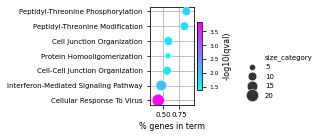

In [21]:
TOP_N = 15
df2plot = sigup_pathway.sort_values('percent', ascending=False).reset_index()
df2plot['-log10(qval)'] = -np.log10(df2plot['qval'])
norm = plt.Normalize(df2plot['-log10(qval)'].min(), df2plot['-log10(qval)'].max())
sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
sm.set_array([])

d2plot = df2plot.iloc[:TOP_N,:]
grouped_data = makeBins(d2plot['odds'], n_bins=5)
d2plot['size_category'] = grouped_data['Group']

# map bins to size
orig_bins  = np.append(0, d2plot['size_category'].astype(int).sort_values().unique())
mapped_bins= np.interp(orig_bins, (orig_bins.min(), orig_bins.max()), (0, 150))

fig, ax = plt.subplots(1,1, figsize=(1,1.8))
# fig, ax = plt.subplots(1,1, figsize=(1,2.5))
ax.grid(True)
g = sns.scatterplot(data=d2plot, x='percent', y='term_clean',
                    hue='-log10(qval)', palette='cool', ax=ax, zorder=3,
                    hue_norm=(d2plot['-log10(qval)'].min(), d2plot['-log10(qval)'].max()),
                    size='size_category',
                    sizes=dict(zip(list(orig_bins.astype(str)),mapped_bins)),
                    linewidth=0.5)

# Remove only hue legend, keep size legend
handles, labels = g.get_legend_handles_labels()
size_idx = [i for i,v in enumerate(labels) if v=='size_category'][0]
size_handles = handles[size_idx:]
size_labels = labels[size_idx:]

plt.legend(
    size_handles, 
    size_labels, 
    bbox_to_anchor=(2,0), 
    loc='lower left',
    frameon=False,
    fontsize=7,
)
delta = 0.1
ax.set_xlim(np.floor(np.min(ax.get_xlim())*100)/100 - delta,np.ceil(np.max(ax.get_xlim())*100)/100 + delta)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7); #7
ax.set_ylabel('', fontsize=6);
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7); #7
ax.set_xlabel('% genes in term', fontsize=8);
cbar = fig.colorbar(sm, label='-log10(qval)', shrink=0.7, aspect=20*0.7, ax=ax)
cbar.ax.tick_params(labelsize=6) 
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), size=8) ;

plt.tight_layout()
plt.savefig('figures/T21up_hypergeo_second_analysis_only.pdf', dpi=300)

In [22]:
fisher_output, sigdn_pathway = pathwayFisher(terms, HIgnees, sigdn_genes, MIN_NUM_GENES = 3, QVAL_THRESH = 0.05, sort_by='percent', ascending=False)
# sigdn_pathway['term_clean'] = sigdn_pathway.index.str.split('\s\(GO.', expand=True).get_level_values(0)
# sigdn_pathway = sigdn_pathway.reset_index().set_index('term_clean')
# fisher_output
sigdn_pathway

sf.fisher_representation on: exp_genes 12057, zon_genes 59. zon_path 0 at MIN_NUM_GENES 3, QVAL_THRESH 0.05


,pval,odds,genes,percent,qval


# pbulk analysis

In [23]:
logFC_THRESH = 0.2
FDR_THRESH = 0.1

In [24]:
# expression of enriched genes
# fname1 = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
fname2 = '../data/allGenes_log2FC_splitbyCT.csv'
# df = pd.concat([pd.read_csv(fname1), pd.read_csv(fname2)], axis=0)
df = pd.read_csv(fname2)
print(f'{df.shape[0]} total genes')

union_sigup = df[(df['logFC'] > logFC_THRESH) & (df['FDR'] < FDR_THRESH)]
union_sigup_unique = union_sigup.sort_values(by='logFC', ascending=False).drop_duplicates(subset='geneSym', keep='first')
print(f'up regulated {len(union_sigup_unique)}')

union_sigdn = df[(df['logFC'] < -logFC_THRESH) & (df['FDR'] < FDR_THRESH)]
union_sigdn_unique = union_sigdn.sort_values(by='logFC', ascending=False).drop_duplicates(subset='geneSym', keep='first')
print(f'dn regulated {len(union_sigdn_unique)}')

24479 total genes
up regulated 180
dn regulated 59


In [25]:
# get terms from hypergeometric analysis
dd = {}
for term in sigup_pathway.index:
    genes = sigup_pathway.loc[term, 'genes']
    dd[term] = list(set(union_sigup['geneSym']) & set(genes))

# merge keys and values of hypergeometric output
term_groups = {'Peptidyl-Threonine' : ['Peptidyl-Threonine Phosphorylation','Peptidyl-Threonine Modification'],
               'Cellular topology': ['Cell Junction Organization','Cell-Cell Junction Organization'],
               'Protein Homooligomerization': ['Protein Homooligomerization'],
               'INF pathway': ['Interferon-Mediated Signaling Pathway','Cellular Response To Virus']
              }

# check if all terms included in 'term_groups'
s1 = set(dd.keys())
s2 = set([x for xs in term_groups.values() for x in xs])
if (len(s2-s1)) & (len(s1-s2)) is 0 : print('all trems included!')
    
# prep for plot
dict2plot = {}
for k,v in term_groups.items():
    gg = [dd.get(key, None) for key in v]
    gg = [x for xs in gg for x in xs]
    gg = list(np.unique(gg))
    dict2plot[k] = gg

# plot genes in single cell data [basedon dict2plot ordered manually]
markers = {'Peptidyl-Threonine': ['DYRK1A', 'HIPK2', 'MAPK1','PDPK1', 'MARK2'],
             'Cellular topology': ['TLN1','OCLN', 'AJM1', 'APP', 'CXADR', 'DSP'],
             'Protein Homooligomerization': ['SAMD1', 'LETM1', 'NOL3', 'USP16'],
             'INF pathway': ['RRP1B', 'GBF1', 'IFNAR2', 'IFNAR1', 'IFNGR2', 'IL10RB']}
bdata = adata[adata.obs['celltype'].isin(['thy_TH_processing', 'thy_Lumen-forming'])]


all trems included!


In [26]:
temp = pd.DataFrame([item for sublist in markers.values() for item in sublist], columns=['gene'])
temp = sf.addChrInfo(temp, geneColumn='gene')
temp[temp['chr'] == 'chr21']

,gene,chr,ensID
0,DYRK1A,chr21,ENSG00000157540
8,APP,chr21,ENSG00000142192
9,CXADR,chr21,ENSG00000154639
14,USP16,chr21,ENSG00000156256
15,RRP1B,chr21,ENSG00000160208
17,IFNAR2,chr21,ENSG00000159110
18,IFNAR1,chr21,ENSG00000142166
19,IFNGR2,chr21,ENSG00000159128
20,IL10RB,chr21,ENSG00000243646


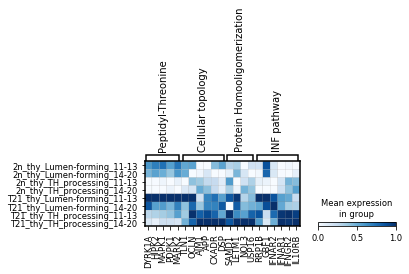

In [27]:
sc.pl.matrixplot(bdata, var_names=markers, groupby=['karyotype','celltype','age_group'], standard_scale='var',
                 cmap='Blues', figsize=(4.5, 1.2), save="go_genes_second_analysis.pdf")

# GO plot with marsilea

In [28]:
import marsilea as ma
import marsilea.plotter as mp
import matplotlib as mpl

In [29]:
long_list = [item for sublist in dict2plot.values() for item in sublist]

exp = bdata[:, long_list]
mm = pd.concat([exp.to_df(), bdata.obs[['karyotype','celltype','age_group']]], axis=1).groupby(['karyotype','celltype','age_group']).mean().reset_index()
metadata = mm[['karyotype','celltype','age_group']]
data = mm.loc[:,mm.columns.isin(set(mm.columns)-set(metadata.columns))] #keep the order of longlist

In [30]:
terms, markers = [], []
for c, ms in dict2plot.items():
    terms += [c] * len(ms)
    markers += ms
uni_terms = list(dict2plot.keys())

In [31]:
metadata = metadata.replace({'thy_Lumen-forming':'fTFC2', 'thy_TH_processing':'fTFC1'})
metadata['age_group'] = metadata['age_group'].astype(str)+' PCW'
side_labels = metadata[['celltype','age_group']].apply(lambda r: ' | '.join(r), axis=1)
kar_labels = list(metadata['karyotype'])

In [32]:
dict2plot

{'Peptidyl-Threonine': ['DYRK1A', 'HIPK2', 'MAPK1', 'MARK2', 'PDPK1'],
 'Cellular topology': ['AJM1', 'APP', 'CXADR', 'DSP', 'OCLN', 'TLN1'],
 'Protein Homooligomerization': ['LETM1', 'NOL3', 'SAMD1', 'USP16'],
 'INF pathway': ['GBF1', 'IFNAR1', 'IFNAR2', 'IFNGR2', 'IL10RB', 'RRP1B']}

In [33]:
pd.Series(terms).unique().tolist()

['Peptidyl-Threonine',
 'Cellular topology',
 'Protein Homooligomerization',
 'INF pathway']

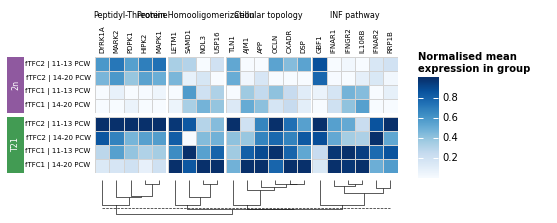

In [34]:
h, w = data.shape
data = (data - data. min()) / (data. max() - data. min())
m = ma.Heatmap(data,
    height=h / 5,
    width=w / 5,
    cmap="Blues",
    linewidth=0.5,
    linecolor="lightgray",
    label="Normalised mean\nexpression in group",
)
m.add_top(mp.Labels(long_list, fontsize=7), pad=0.05)
m.group_cols(terms, spacing=0.005, order=list(dict2plot.keys()))
m.add_top(mp.Chunk(list(dict2plot.keys()), rotation=0, fontsize=8))
m.add_dendrogram("bottom", pad=0.1, add_base=True)
m.group_rows(kar_labels, spacing=0.04)
m.add_left(mp.Labels(side_labels, fontsize=7), pad=0.05)
m.add_left(mp.Chunk(list(np.unique(kar_labels)), fontsize=8, fill_colors=['#8F599F','#429B53']))

m.add_legends()
m.render()
# plt.savefig('figures/terms_heatmap.pdf', dpi=300)

# venn diagram sig gene 

In [35]:
logFC_THRESH = 0.2
FDR_THRESH = 0.05

## upregulated genes

In [36]:
fname = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
df = pd.read_csv(fname)
print(f'{df.shape[0]} total genes')

sig_genes = df[(df['logFC'] > logFC_THRESH) & (df['FDR'] < FDR_THRESH)] #upregulated only
df2plot1 = sig_genes[sig_genes['comparison'].isin(['fTFC1_11_13','fTFC2_11_13'])] #celltype
print(f'{df2plot1.shape[0]} significant genes')

df2plot2 = sig_genes[sig_genes['comparison'].isin(['fTFC1_14_20','fTFC2_14_20'])] #celltype
print(f'{df2plot2.shape[0]} significant genes')

# time insensitive analysis
fname = '../data/allGenes_log2FC_splitbyCT.csv'
T21df = pd.read_csv(fname)
T21sig_genes = T21df[(T21df['logFC'] > logFC_THRESH) & (T21df['FDR'] < FDR_THRESH)] #upregulated only
print(f'{T21sig_genes.shape[0]} significant genes')

49229 total genes
12 significant genes
108 significant genes
186 significant genes


In [37]:
# set venn helper function
def getVennGenesInChr21(v, genes_union):
    genes = {
        '100' : list(a-b-c),
        '110' : list(a&b-c),
        '101' : list(a&c-b),
        '010' : list(b-a-c),         
        '011' : list(b&c-a),
        '001' : list(c-a-b),
        '111' : list(a&b&c)}
    for key,val in genes.items():
        if val!=[]:
            aa = genes_union.loc[genes[key]]
            all_count = aa.shape[0]
            chr21_count = (aa['chr'] == 'chr21').sum()
#             print(f"{key}:{chr21_count}")
            v.get_label_by_id(key).set_text(f"{all_count}/{chr21_count}")
    return genes


genes_union: 146


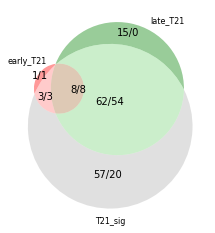

In [38]:
a = set(df2plot1['geneSym'].tolist()) #early_T21
b = set(df2plot2['geneSym'].tolist()) #late_T21
c = set(T21sig_genes['geneSym'].tolist()) #T21sig

genes_union = pd.concat([df2plot1,df2plot2,T21sig_genes], axis=0).drop_duplicates('geneSym')
genes_union_GC = genes_union[['geneSym','chr']].set_index('geneSym')
print(f'genes_union: {len(genes_union_GC)}')

v3 = venn3([a, b, c], set_labels=('early_T21', 'late_T21', 'T21_sig'), set_colors=('r', 'g', '0.7'))
for text in v3.set_labels:
    text.set_fontsize(8)
sections = getVennGenesInChr21(v3, genes_union_GC)
plt.savefig('figures/venn_sigup_genes.pdf', dpi=300)
plt.show()

In [39]:
print(len(sections['100']))
print(sections['100'])

1
['RCAN1']


In [40]:
print(len(sections['010']))
genes_union[genes_union['geneSym'].isin(sections['010'])].sort_values('logFC', ascending=False)['geneSym'].tolist()

15


['MT1H',
 'RDH12',
 'NQO1',
 'TSPAN1',
 'FRMPD2',
 'CIB4',
 'C19orf33',
 'SH3BP5',
 'MC1R',
 'SULT1A2',
 'MT1X',
 'NMB',
 'OTOS',
 'SDSL',
 'WARS']

In [41]:
N=15
print(len(sections['001']))
genes_union[genes_union['geneSym'].isin(sections['001'])].sort_values('logFC', ascending=False)[['geneSym','chr']].head(N)

57


,geneSym,chr
12762,AMH,chr19
91,AGMO,chr7
120,ULBP1,chr6
129,CES3,chr16
76,KRTAP10-4,chr21
118,PRR9,chr1
58,COL18A1,chr21
134,NPDC1,chr9
12763,HSF2BP,chr21
85,LCA5L,chr21


In [42]:
# union_sigup_unique[union_sigup_unique['geneSym'].isin(sections['001'])].sort_values('logFC', ascending=False)[['geneSym','chr']].to_csv('./results/T21_time_insensitive_unique_genes.csv', index=False)

## Dn regulated genes

In [43]:
fname = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
df = pd.read_csv(fname)
print(f'{df.shape[0]} total genes')

sig_genes = df[(df['logFC'] < -logFC_THRESH) & (df['FDR'] < FDR_THRESH)] #upregulated only
df2plot1 = sig_genes[sig_genes['comparison'].isin(['fTFC1_11_13','fTFC2_11_13'])] #celltype
print(f'{df2plot1.shape[0]} significant genes')

df2plot2 = sig_genes[sig_genes['comparison'].isin(['fTFC1_14_20','fTFC2_14_20'])] #celltype
print(f'{df2plot2.shape[0]} significant genes')

# time insensitive analysis
fname = '../data/allGenes_log2FC_splitbyCT.csv'
T21df = pd.read_csv(fname)
T21sig_genes = T21df[(T21df['logFC'] < -logFC_THRESH) & (T21df['FDR'] < FDR_THRESH)] #upregulated only
print(f'{T21sig_genes.shape[0]} significant genes')

49229 total genes
0 significant genes
29 significant genes
28 significant genes


genes_union: 46


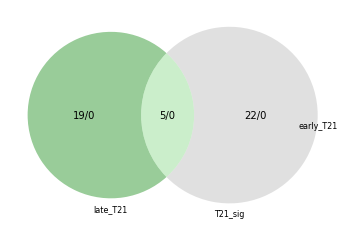

In [44]:
a = set(df2plot1['geneSym'].tolist()) #early_T21
b = set(df2plot2['geneSym'].tolist()) #late_T21
c = set(T21sig_genes['geneSym'].tolist()) #T21sig

genes_union = pd.concat([df2plot1,df2plot2,T21sig_genes], axis=0).drop_duplicates('geneSym')
genes_union_GC = genes_union[['geneSym','chr']].set_index('geneSym')
print(f'genes_union: {len(genes_union_GC)}')

v3 = venn3([a, b, c], set_labels=('early_T21', 'late_T21', 'T21_sig'), set_colors=('r', 'g', '0.7'))
for text in v3.set_labels:
    text.set_fontsize(8)
sections = getVennGenesInChr21(v3, genes_union_GC)
plt.savefig('figures/venn_sigdn_genes.pdf', dpi=300)
plt.show()

In [45]:
print(len(sections['010']))
genes_union[genes_union['geneSym'].isin(sections['010'])].sort_values('logFC', ascending=False)[['geneSym','chr']].head(N)

19


,geneSym,chr
80,NOP53,chr19
43,PALM2-AKAP2,chr9
83,CMTM7,chr3
73,MAP3K20,chr2
68,FSTL1,chr3
60,TENM3,chr4
61,MFGE8,chr15
92,CITED4,chr1
25756,CROCC,chr1
71,SORCS1,chr10


In [46]:
N=22
print(len(sections['001']))
genes_union[genes_union['geneSym'].isin(sections['001'])].sort_values('logFC', ascending=False)[['geneSym','chr']].head(N)

22


,geneSym,chr
123,COPS2,chr15
98,PIAS3,chr1
101,SLC36A4,chr11
124,RCAN2,chr6
95,PSMD5,chr9
110,BICC1,chr10
12781,DYRK1B,chr19
60,LBR,chr1
12776,ILF2,chr1
12778,COPS6,chr7
